In [1]:
#image analysis
import sys
sys.path.append("../../")

import json
import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from skimage.transform import resize

p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
#p.save_folder = "G:/DREAM/from_github/thesis/Figures/OJIP/"
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"

label_intensity = r"$I$ ($\mathrm{\mu E.m^{-2}.s^{-1}}$)"
label_time = "$t$ (s)"

import mvgavg

import scipy

import tifffile as tiff

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity


import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib inline
#pympl
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
from alienlab.regression_func import platt, residuals
from alienlab.utils import clip, marker, hatch, color, linestyles
from alienlab.segment import uniform_mask, label_to_data
from alienlab.widget import click_to_graph
#%matplotlib inline

from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func


from mvgavg import mvgavg



from collections import OrderedDict

keys = list(linestyles.keys())


In [2]:
#file_path = "ENTER NAME OF THE FILE YOU DROPPED IN THE FILE SECTION HERE" 
file_folder = 'LEAF1_filter_665_690/'#G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2021_11_03_OJIP_calibration/FOLDER_2021_11_03_OJIP_actiivated_1/'
#askdirectory(title = 'Select an experiment folder', initialdir="G:/DREAM/from_github/PAMFluo/Experiments")  # pops up a window to select your file 
# uncomment this line if you use this jupyter notebook locally
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-06-24_12_12_Ek_video'


In [3]:
def sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    y = F0 + Aoj*(1-np.exp(-koj*tdata))**soj + Aji*(1-np.exp(-kji*tdata))**sji +  Aip*(1-np.exp(-kip*tdata))**sip
    
    return y

def d1_sigmoidal_OJIP(A, k, s, tdata):
    y = A*s*k*(1-np.exp(-tdata*k))**(s-1)*np.exp(-tdata*k)
    return y

def d2_sigmoidal_OJIP(A, k, s, tdata):
    y = -(s*k*k*(1-np.exp(-tdata*k))**s*(np.exp(k*tdata)-s))/(np.exp(tdata*k)-1)**2
    return y



def diff_sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    
    yoj = d1_sigmoidal_OJIP(Aoj, koj, soj, tdata)
    yji = d1_sigmoidal_OJIP(Aji, kji, sji, tdata)
    yip = d1_sigmoidal_OJIP(Aip, kip, sip, tdata)
    return yoj + yji + yip
    
def diff2_sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    
    yoj = d2_sigmoidal_OJIP(Aoj, koj, soj, tdata)
    yji = d2_sigmoidal_OJIP(Aji, kji, sji, tdata)
    yip = d2_sigmoidal_OJIP(Aip, kip, sip, tdata)
    return yoj + yji + yip
    

def multiexp_fit(f, N = 10, bode_folder =  "2022-07-29_16_33_bode_diagram", Nlog=10000 ):
    file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
    file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
    
    #(voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
    
    with open(f + "/config.json", 'r') as j:
         contents = json.loads(j.read())
    voltage = np.max([contents['limit_blue'], contents['limit_red'], contents['limit_green'], contents['limit_purple']])
    filter = contents['actinic_filter']
    
    data_sequence = pd.read_csv(file_path)
    amp_seq = pd.read_csv(file2)

    V = VoltageIntensity(folder = bode_folder)#"2022-07-28_10_10_bode_diagram")2022-01-13_12_02_bode_diagram
    intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
    intensity_purple=  V.get_intensity_voltage('purple', int(filter), voltage/100)*1e6
    #fluo = amplitude

    time_array = np.array(data_sequence["time (s) intensity"])

    fluo = np.array(data_sequence["voltage (V) intensity"])
    blank = np.mean(fluo[0:10])
    fluo = fluo-blank
    fluo_ref = fluo/fluo.max()
    ind_ref = (fluo_ref>0.1)#*(time_array>4e-5)    
    
    
    binit = True
    t = mvgavg(time_array[ind_ref], N, binning = binit)
    y = mvgavg(fluo[ind_ref], N, binning = binit)
    #t = time_array[ind_ref]
    #y = fluo[ind_ref]
    t-=t[0]
    
    ind= np.unique(np.logspace(np.log10(1), np.log10(len(t)-1), Nlog).astype(int))#70
    t = t[ind]
    y = y[ind]
    #poly = np.polyfit(np.log(t), y,20)
    #yp = np.polyval(poly, np.log(t))
    dF = fluo.max()-fluo.min()
    x0 = [fluo.min(), dF/2, 5E3, 1.24, dF/4, 0.06E3, 1.2, dF/4, 0.0023E3, 8.2]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = ([-1e5,-1e5, 0, 1,-1e5, 0, 1,-1e5, 0, 1], [1e5,1e5, 1e5, 20,1e5, 1e5, 20,1e5, 1e5, 20]),
                                args = (t, y, sigmoidal_OJIP))
    
    tau = parameters_estimated.x[2]
    ypred = sigmoidal_OJIP(parameters_estimated.x, t)
    return intensity, parameters_estimated.x, t, y, ypred, voltage, y.max(), intensity_purple, filter


def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * (1 - np.exp(-xdata/tau))**1.24 + y0


def exp_decay_dual(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    A2 = parameters[3]
    tau2 = parameters[4]
    return A * (1 - np.exp(-xdata/tau))**1.24 + A2 * (1 - np.exp(-xdata/tau2))**1.2+ y0


def get_fit(decay, time):    

    time_spread = time.max()-time.min()
    start = np.mean(decay[0])
    stop = np.mean(decay[-10:])
    x0 = [start, 1/10, stop]#, start, 1/10]
    time = time-time[0]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (time, decay, exp_decay))
    #if tau >  (second-first)//10: #if too high
    #    tau =  (second-first)//10
    #if tau < 3: #if too low, increase it
    #        tau = 5
    tau = parameters_estimated.x[1]
    pos_tau = find_nearest(time, tau)
    x0 = parameters_estimated.x #initial guess: parameters from previous fit
    #second fit
    parameters_estimated  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                            args = (time[0:int(pos_tau*5)], decay[0: int(pos_tau*5)], exp_decay))
    return parameters_estimated.x

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## Figure Main Text

LEAF1_blue_665_690/


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7840.24331524865 3721.859864860173
LEAF1_blue_665_690/


C:\Users\Alienor\AppData\Local\Temp\ipykernel_15104\2957775714.py:120: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.24 + y0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


array([1.93166952e+00, 6.15507490e-05, 1.00133877e+00])

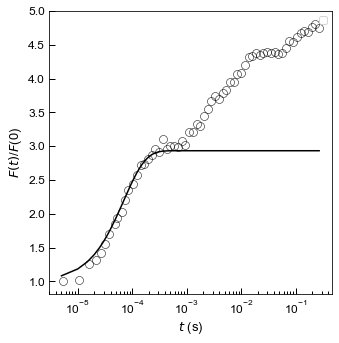

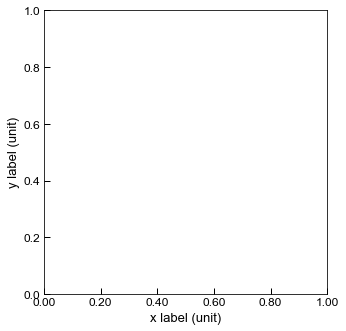

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [4]:
if True:
    folder_list = ['LEAF1_blue_665_690/']
    p.figsize = (10, 10)
    fig1 = p.set_figure("%e", "%0.1f")
    ax1 = plt.gca()
    fig2 = p.set_figure("%0.2f", "%0.1f")
    ax2 = plt.gca()
    U,V = 16, 15
    for N in [U, V]:
        for i, folder in enumerate(folder_list[0:1]): 
            print(folder)

            for f in glob.glob(folder + "/*pulse*")[0:1]:
                if N==U:
                        intensity, params, t, y, ypred, voltage, maxi, purple, filter = multiexp_fit(f, N=N, Nlog=70)
                        print(intensity, purple)
                        Norm = y[0]
                        ax1.semilogx(t, y/Norm, marker = "o", c = "none", markeredgecolor="k", markeredgewidth=0.5, markersize=8)
                        #ax1.semilogx(t, ypred, "--k")

                if N==V:    
                        intensity, params, t, y, ypred, voltage, maxi, purple, filter = multiexp_fit(f, N=N)

                        pos = 3/params[2]
                        y = y/Norm
                        pos_tau = find_nearest(t, pos)
                        params = get_fit(y[:pos_tau], t[:pos_tau])

                        D = 400
                        pos_tau = find_nearest(t, D*params[1])
                        ypred =  exp_decay(params, t[:pos_tau*D])
                        ax1.semilogx(t[:pos_tau*D],ypred, "k")


        ax1.legend()
        ax1.set_xlabel(label_time)
        ax1.set_ylabel("$F(t)$/$F$(0)")

        p.save_name = "OJIP_MT"
        p.saving(fig1)
params

In [5]:
tau = params[1]
print(tau*1e6)
I = 1/1.44/tau
print(I)

61.55074904366958
11282.469429441771


In [6]:
1350-5000

-3650

### test

In [7]:
folder_list =  ['LEAF1_blue_506_675/','LEAF1_blue_665_690/',  'LEAF1_purple_665_690/', 'LEAF1_green_665_690/', 'LEAF1_red_665_690/'] 

LEAF1_blue_665_690/
LEAF1_blue_665_690\2022-07-29_10_52_OJIP_pulse_393_blue
7151.79252666145 3244.9829517227304
LEAF1_purple_665_690/
LEAF1_purple_665_690\2022-07-29_11_17_OJIP_pulse_393_purple
7151.79252666145 3244.9829517227304
LEAF1_green_665_690/
LEAF1_green_665_690\2022-07-29_11_42_OJIP_pulse_393_green
7151.79252666145 3244.9829517227304
LEAF1_red_665_690/
LEAF1_red_665_690\2022-07-29_12_00_OJIP_pulse_337_blue


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6389.573607086648 2773.4268431477435
LEAF1_blue_665_690/
LEAF1_blue_665_690\2022-07-29_10_52_OJIP_pulse_393_blue
7151.79252666145 3244.9829517227304
LEAF1_purple_665_690/
LEAF1_purple_665_690\2022-07-29_11_17_OJIP_pulse_393_purple


C:\Users\Alienor\AppData\Local\Temp\ipykernel_15104\2957775714.py:120: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.24 + y0


7151.79252666145 3244.9829517227304
LEAF1_green_665_690/
LEAF1_green_665_690\2022-07-29_11_42_OJIP_pulse_393_green


C:\Users\Alienor\AppData\Local\Temp\ipykernel_15104\2957775714.py:120: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.24 + y0


7151.79252666145 3244.9829517227304
LEAF1_red_665_690/
LEAF1_red_665_690\2022-07-29_12_00_OJIP_pulse_337_blue


C:\Users\Alienor\AppData\Local\Temp\ipykernel_15104\2957775714.py:120: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.24 + y0
C:\Users\Alienor\AppData\Local\Temp\ipykernel_15104\2957775714.py:120: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.24 + y0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6389.573607086648 2773.4268431477435


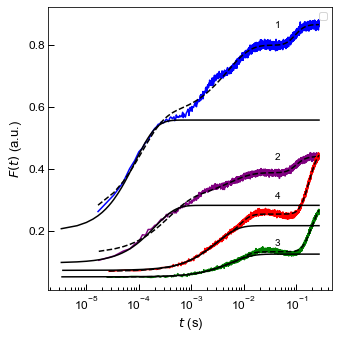

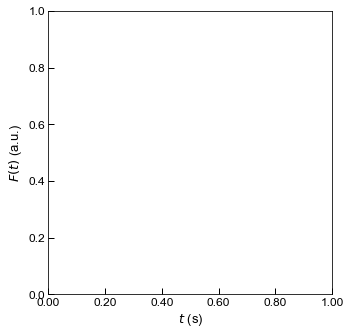

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
fig2 = p.set_figure("%0.2f", "%0.1f")
ax2 = plt.gca()
for N in [50, 10]:
    for i, folder in enumerate(folder_list[1:]): 
        print(folder)
        
        for f in glob.glob(folder + "/*pulse*")[1:2]:

            if 'e_0_' not in f:
                print(f)
                intensity, params, t, y, ypred, voltage, maxi, purple, filter = multiexp_fit(f, N=N)
                print(intensity, purple)
                
                if N==50:
                    ax1.semilogx(t, y, c =  ["blue", "purple", "green", "red"][i])
                    ax1.annotate(i+1, (t[-2000],y[-700]), xycoords = "data")
                    ax1.semilogx(t, ypred, "--k")

                #ax1.plot(t, y, c =  "grey", label = f[0:5])
                #ax1.plot(t, ypred, c = "k")

                if N==10:
                    pos = 3/params[2]
                    #if pos < 5e-4:
                    #    pos = 5e-4
                    #ax1.scatter(pos, sigmoidal_OJIP(params, pos), c = 'k', s = 300)
                    pos_tau = find_nearest(t, pos)
                    params = get_fit(y[:pos_tau], t[:pos_tau])

                    D = 400
                    pos_tau = find_nearest(t, D*params[1])
                    #ax2.semilogx(t[:pos_tau*D], y[:pos_tau*D], c="grey")
                    ypred =  exp_decay(params, t[:pos_tau*D])
                    ax1.semilogx(t[:pos_tau*D],ypred, "k")
                    #ax2.annotate(i, (t[0],ypred[1]), xycoords = "data")


                    #plt.scatter(intensity, 1/params[1])
    ax1.legend()
    ax1.set_xlabel(label_time)
    ax1.set_ylabel("$F(t)$ (a.u.)")
    ax2.set_xlabel(label_time)
    ax2.set_ylabel("$F(t)$ (a.u.)")
    #if N==50:
    p.save_name = "fits_various_colors_JC"
    p.saving(fig1)
    #if N==10:
    #    fig2.savefig(p.save_folder + "/fits_various_colors_exp.png")

from sympy import *
x = symbols("x")
A = symbols("A")
k = symbols("k")
s = symbols("s")

F = A*(1-exp(-x*k))**s
expr = diff(diff(F, x),x)
print(solve(expr, x))
D2 = expr.subs([(A, params[1]),(k,params[2]), (s, params[3])]) +expr.subs([(A, params[4]),(k,params[5]), (s, params[6])]) + expr.subs([(A, params[7]),(k,params[8]), (s, params[9])]) 
#solve(D2, x)

LEAF1_blue_506_675/
LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
LEAF1_blue_506_675\2022-07-29_10_15_OJIP_pulse_393_blue
LEAF1_blue_506_675\2022-07-29_10_16_OJIP_pulse_337_blue
LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_225_blue
LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_281_blue
LEAF1_blue_506_675\2022-07-29_10_18_OJIP_pulse_168_blue
LEAF1_blue_506_675\2022-07-29_10_19_OJIP_pulse_112_blue
LEAF1_blue_506_675\2022-07-29_10_20_OJIP_pulse_56_blue
LEAF1_blue_506_675\2022-07-29_10_21_OJIP_pulse_0_blue
LEAF1_blue_506_675\2022-07-29_10_21_OJIP_pulse_20_blue
LEAF1_blue_506_675\2022-07-29_10_22_OJIP_pulse_73_blue
LEAF1_blue_506_675\2022-07-29_10_23_OJIP_pulse_127_blue
LEAF1_blue_506_675\2022-07-29_10_24_OJIP_pulse_181_blue
LEAF1_blue_506_675\2022-07-29_10_25_OJIP_pulse_235_blue
LEAF1_blue_506_675\2022-07-29_10_26_OJIP_pulse_288_blue
LEAF1_blue_506_675\2022-07-29_10_26_OJIP_pulse_342_blue
LEAF1_blue_506_675\2022-07-29_10_27_OJIP_pulse_396_blue
LEAF1_blue_506_675\2022-07-29_10_

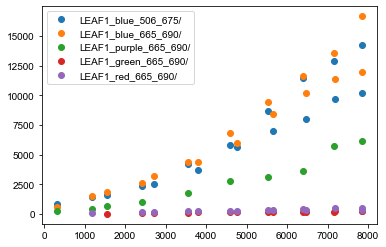

In [9]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


for i in [3]:
    tot_int = {}
    tot_tau = {}
    tot_maxi = {}
    tot_voltage = {}
    tot_purple = {}
    plt.figure()

    for folder in folder_list: 
        print(folder)
        tot_int[folder] = []
        tot_tau[folder] = []
        tot_maxi[folder] = []
        tot_voltage[folder] = []
        tot_purple[folder] = []

        for f in glob.glob(folder + "/*pulse*"):
            print(f)
            if 'e_0_' not in f:
                intensity, params, t, y, ypred, voltage, maxi, intensity_purple, filter = multiexp_fit(f)

                pos = i/params[2]

                pos_tau = find_nearest(t, pos)

                params = get_fit(y[:pos_tau], t[:pos_tau])
                tot_int[folder].append(intensity)
                tot_tau[folder].append(params)
                tot_maxi[folder].append(maxi)
                tot_voltage[folder].append(voltage)
                tot_purple[folder].append(intensity_purple)

        plt.plot(tot_int[folder], 1/np.array(tot_tau[folder])[:,1], "o", label = folder)
    
        plt.legend()  

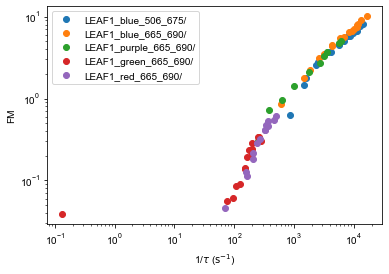

In [10]:
plt.figure()
for folder in folder_list:
    maxi = np.array(tot_maxi[folder])
    if "blue" in folder or "purple" in folder:
        maxi *= 10
    #plt.plot(tot_int[folder], maxi , "o", label = folder)
    plt.loglog( 1/np.array(tot_tau[folder])[:,1], maxi , "o", label = folder)
    plt.xlabel(p.label_tau)
    plt.ylabel("FM")
plt.legend()

## 1/tau as equivalent to blue light intensity for 4 colors

LEAF1_blue_665_690/
[450 393 281 337 225 168 112  56  20  73 127 181 235 288 342 396 450]
LEAF1_purple_665_690/
[450 393 337 225 281 168 112  56  20  73]
LEAF1_green_665_690/
[450 393 281 337 225 168 112  73 127 181 235 288 342 396 450]
LEAF1_red_665_690/
[450 337 281 225 112 168  56 127 181 235 288 342 396 450]


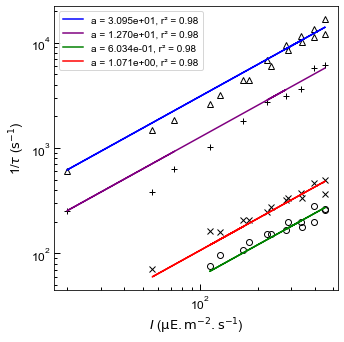

<Figure size 432x288 with 0 Axes>

In [11]:
p.ylabel = p.label_tau
p.xlabel = p.label_intensity
fig = p.set_figure("%d", "%0.0e")


for i, folder in enumerate(folder_list[1:]):
    intensities = np.array(tot_voltage[folder])
    
    print(folder)
    print(intensities)
    taus = 1/np.array(tot_tau[folder])[:,1]
    Yreg, a, results = regression_linear(intensities, taus)
    ind = taus>10
    plt.loglog(intensities[ind], taus[ind], linestyle="", marker = ["^", "+", "o", "x"][i], markeredgecolor="k", markerfacecolor="none")
    
    plt.loglog(intensities[ind], a*intensities[ind], color = ['blue', 'purple', 'green', 'red'][i], label = "a = %0.3e, r² = %0.2f"%(a, results.rsquared))
    plt.legend()
    plt.xlabel(p.label_intensity)
    plt.ylabel(p.label_tau)
p.save_name = "fit_for_each_color"
u = p.saving(fig)


# powermeter values

In [12]:
#550
dict_green = {
    0: 0,
    55:13.5,
    111:18.5,
    166:23.5,
    222:27.5,
    277:32,
    333:35,
    388:37,
    444:42,}
"""
dict_green = {55.55555555555556: 149.07441299449826,
 111.11111111111111: 306.05763125464296,
 166.66666666666669: 452.31216557739083,
 222.22222222222223: 588.3151345993089,
 277.77777777777777: 715.8894132946795,
 333.33333333333337: 836.6151615567164,
 388.8888888888889: 950.610446361116,
 444.44444444444446: 1057.9609557782685}
"""
#640
dict_red = {
    0: 0,
    55:10,
    111:14,
    166:18,
    222:21,
    277:24,
    333:28,
    388:31,
    444:34,}
"""
dict_red = {55.55555555555556: 123.75621544926872,
 111.11111111111111: 261.73492627572074,
 166.66666666666669: 397.22242859145007,
 222.22222222222223: 528.3906619631629,
 277.77777777777777: 654.6019960308844,
 333.33333333333337: 776.5512283525172,
 388.8888888888889: 892.7605465850573,
 444.44444444444446: 1003.3106480099078}
"""
#480
dict_blue = {
    0: 0,
    55:81,
    111:141,
    166:200,
    222:258,
    277:308,
    333:355,
    388:404,
    444:445,}



def dict_to_func(dict_amplitude):
    x = []
    y = []
    for k in dict_amplitude.keys():
        x.append(k)
        y.append(dict_amplitude[k])
    x = np.array(x)
    y = np.array(y)
    func = get_affine_func(x, y)
    return func
    
def amp_to_eins(dict_amplitude, amplitude, lbd):
    #ref: https://fr.wikipedia.org/wiki/Einstein_(unit%C3%A9_de_mesure)
    func = dict_to_func(dict_amplitude)
    power = func(amplitude)
    S = 0.25
    eins=power*1e-3*1e3*lbd/120/S
    
    return eins

## Blue and purple: voltageIntensityClass with dronpa2, green and red: powermeter. DDAO instead ?

C:\Users\Alienor\anaconda3\envs\tf-gpu\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Alienor\anaconda3\envs\tf-gpu\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              581.7
Date:                Wed, 08 Feb 2023   Prob (F-statistic):                    5.24e-14
Time:                        10:09:59   Log-Likelihood:                         -147.51
No. Observations:                  17   AIC:                                      297.0
Df Residuals:                      16   BIC:                                      297.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

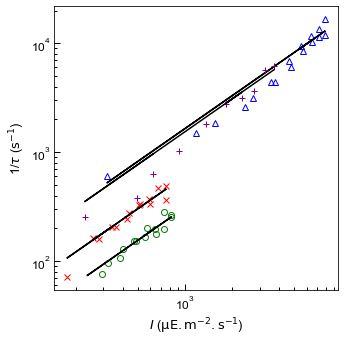

<Figure size 432x288 with 0 Axes>

In [13]:
dicts = [dict_blue, dict_blue, dict_green, dict_red]
RED = 630
dico_sigma =  {405:[], 470:[], 550:[], RED:[]}
dico_sigma_err = {405:[], 470:[], 550:[], RED:[]}
lbd =  [470, 405, 550, RED]
    
sigma = []
error = []

fig = p.set_figure("%d", "%d")

ax2 = plt.gca()   

for i, folder in enumerate(folder_list[1:]):
    voltage = np.array(tot_voltage[folder])
    taus = 1/np.array(tot_tau[folder])[:,1]
    
    
    if i<1:
        eins =  np.array(tot_int[folder])
        
    elif i==1:
        eins =  np.array(tot_purple[folder])
    
    else:
        eins = amp_to_eins(dicts[i], voltage,lbd[i])
    
    #print(eins)
    Yreg, a, results = regression_linear(eins, taus)
    print(results.summary())

    sigma.append(a[0])
    error.append(results.bse[0])
    ind = taus>10
    ax2.loglog(eins[ind],taus[ind],  linestyle="", marker = ["^", "+", "o", "x"][i], markerfacecolor="none", markeredgecolor = ['blue', 'purple', 'green', 'red'][i])
    ax2.plot(eins, a*eins, color = "k", label = "a = %0.3e, r² = %0.2f"%(a, results.rsquared))
    #ax2.legend()
    ax2.set_xlabel(p.label_intensity)
    ax2.set_ylabel(p.label_tau)
    
    dico_sigma[lbd[i]].append(a[0])
    dico_sigma_err[lbd[i]].append(results.bse[0])
p.save_name = "fit_sigma"
p.saving(fig)
    
dico_sigma[470] = [np.mean(dico_sigma[470] )]
dico_sigma_err[470] = [np.mean(dico_sigma_err[470] )]



Text(0, 0.5, 'sigma')

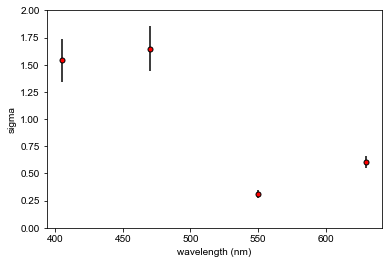

In [14]:
plt.figure()
plt.errorbar(np.array(lbd), np.array(sigma), yerr = 3*np.array(error),  marker='o', mfc='red',
         ms=5, linestyle="", color = "k")
plt.ylim(0, 2)
plt.xlabel("wavelength (nm)")
plt.ylabel("sigma")

## with the max value

[3721.85986486 3244.98295172 2773.42684315 1835.7073673  2302.42369733
 1369.10601208  923.15373937  493.8641744   228.76211524  622.15932864]


{405: [0.001448881014389339],
 470: [0.0011921752058793068],
 550: [0.0003111503709676139],
 630: [0.0006581085864745667]}

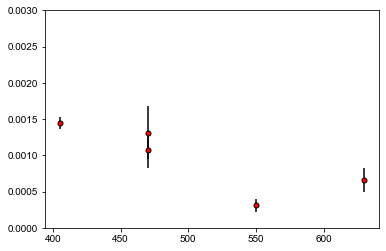

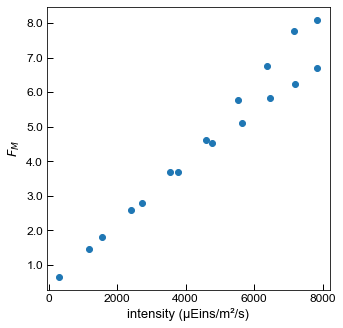

<Figure size 432x288 with 0 Axes>

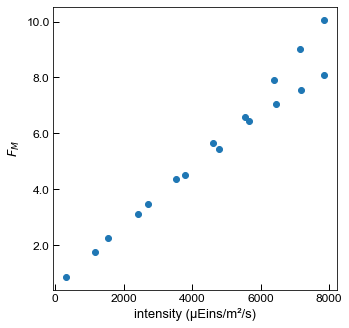

<Figure size 432x288 with 0 Axes>

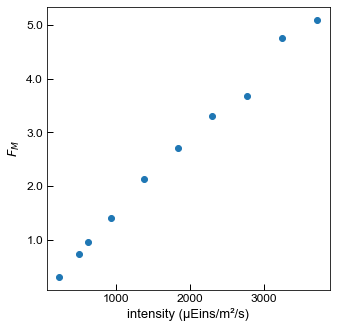

<Figure size 432x288 with 0 Axes>

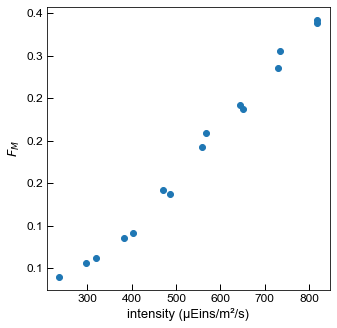

<Figure size 432x288 with 0 Axes>

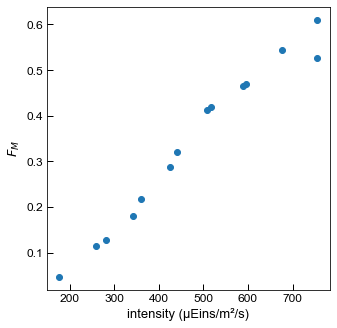

<Figure size 432x288 with 0 Axes>

In [15]:
dicts = [dict_blue, dict_blue, dict_blue, dict_green, dict_red]
dico_maxi =  {405:[], 470:[], 550:[], RED:[]}
dico_maxi_err = {405:[], 470:[], 550:[], RED:[]}
lbd =  [470, 470, 405, 550, RED]
sigma = []
plt.figure()
ax1 = plt.gca()
for i, folder in enumerate(folder_list):
    voltage = np.array(tot_voltage[folder])
    maxis = np.array(tot_maxi[folder])
    if i<3:
        maxis *= 10

            
    if i<2:
        eins =  np.array(tot_int[folder])
        
    elif i==2:
        eins =  np.array(tot_purple[folder])
        print(eins)
    
    else:
        eins = amp_to_eins(dicts[i], voltage,lbd[i])
        
    fig = p.set_figure("%d", "%0.1f")
    plt.scatter(eins, maxis)
    plt.xlabel("intensity (µEins/m²/s)")
    plt.ylabel(r"$F_M$")     
    p.save_name = "fmax_%s"%lbd[i]
    p.saving(fig)
    
    #plt.scatter([lbd[i]]*len(maxis), maxis/eins)
    ax1.errorbar(lbd[i], np.mean(maxis/eins), yerr = np.std(maxis/eins),  marker='o', mfc='red',
         ms=5, linestyle="", color = "k")
    ax1.set_ylim(0, 0.003)
 
    dico_maxi[lbd[i]].append(np.mean(maxis/eins))
    dico_maxi_err[lbd[i]].append(np.std(maxis/eins))
dico_maxi[470] = [np.mean(dico_maxi[470] )]
dico_maxi_err[470] = [np.mean(dico_maxi_err[470] )]
dico_maxi

In [16]:
dico_leaf = np.load("spectra/excitation_dic_leaf.npy", allow_pickle=True).item()
dico_average= np.load("spectra/excitation_dic_average.npy", allow_pickle=True).item()
print(dico_leaf)
print(dico_average)

{405: array([0.67289909, 0.68475427, 0.68866051, 0.6959145 , 0.70075013,
       0.7073493 , 0.71209179, 0.7157978 , 0.72105881, 0.72541468,
       0.73049279, 0.73414277, 0.73641759, 0.7395206 , 0.74189882,
       0.7445665 , 0.74591624, 0.74578574, 0.74732085, 0.74666437,
       0.74642192, 0.74370543, 0.74302199, 0.73982776, 0.73981634,
       0.73718116, 0.73788328]), 470: array([1.05027765, 1.0564406 , 1.03688518, 1.04372267, 1.02467176,
       1.02938807, 1.01757118, 1.02443989, 1.01495984, 1.01727448,
       1.0075645 , 1.00861839, 1.00344406, 1.00137316, 0.99703888,
       0.99363603, 0.98863384, 0.98686808, 0.98018925, 0.97805158,
       0.97325739, 0.97065481, 0.96613183, 0.9636114 , 0.9586295 ,
       0.95556023, 0.95110576]), 550: array([0.37124757, 0.36965377, 0.36645285, 0.36323211, 0.36245175,
       0.36161128, 0.36118465, 0.35939762, 0.35713357, 0.35666567,
       0.35346623, 0.35201754, 0.34809015, 0.34835592, 0.34512827,
       0.34519242, 0.34247636, 0.34260851, 0.34

0.06865112754363802
0.2587854460861382
0.07407797690014417
0.14106013540536633


Text(0, 0.5, 'fluorescence exctation')

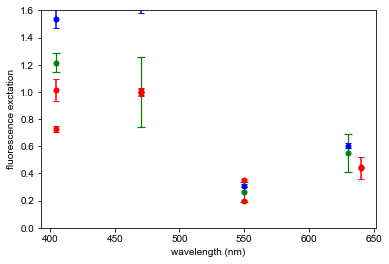

In [17]:

sig = 1

plt.figure()

maxi_graph = []
for lbd in dico_maxi.keys():
    x = dico_maxi[lbd][0]/dico_maxi[470][0]
    err =  dico_maxi_err[lbd][0]/dico_maxi[470][0]
    print(err)
    maxi_graph.append([lbd, x , err] )
    plt.errorbar(lbd, x, yerr = err,   fmt = '--ro', ms=5, 
                 mfc = 'g', elinewidth = 1.2, capsize = 4, capthick = 1.2, color = "g")
    

sigma_graph = []
for lbd in dico_sigma.keys():
    x =  dico_sigma[lbd][0]#/dico_sigma[470][0]
    err =  dico_sigma_err[lbd][0]#/dico_sigma[470][0]
    sigma_graph.append([lbd, x , err] )             
    plt.errorbar(lbd,x, yerr = err,  marker='o', mfc='blue',
         ms=5, linestyle="", color = "b", fmt='--o', capsize = 3)

leaf_graph = []
for lbd in dico_leaf.keys():
    x = np.mean(dico_leaf[lbd])
    err = np.std(dico_leaf[lbd])
    leaf_graph.append([lbd, x , err] )
    plt.errorbar(lbd, x, yerr = err,  marker='o', mfc='red',
         ms=5, linestyle="", color = "r", fmt='--o', capsize = 3)
    
average_graph = []
for lbd in dico_average.keys():
    x = dico_average[lbd][0]
    
    err = dico_average[lbd][1]
    average_graph.append([lbd, x , err] )
    plt.errorbar(lbd, x, yerr = err,  marker='o', mfc='red',
         ms=5, linestyle="", color = "r", fmt='--o', capsize = 3)
    
                    
                
    

plt.ylim(0, 1.6)
plt.xlabel("wavelength (nm)")
plt.ylabel("fluorescence exctation")

In [18]:
sigma_graph

[[405, 1.5400836765426267, 0.06692643413536926],
 [470, 1.6471672544230054, 0.06829629382220453],
 [550, 0.3109686491238928, 0.012543369249548185],
 [630, 0.6054402298199753, 0.018858241576354715]]

In [19]:
average_graph

[[405, 1.0147005863867304, 0.08193619653203629],
 [470, 1.0, 0.021541502363442346],
 [550, 0.2001908461893266, 0.00233680938051354],
 [640, 0.43932164925451356, 0.08056704287873444]]

In [20]:
sigma_pred_graph = [[],[]]
for j, graph in enumerate([leaf_graph, average_graph]):
    graph = np.array(graph)

    for i in range(len(graph)):
        lbd, x, err = graph[i,0], graph[i,1], graph[i,2]
        sigref = [1.65, 1.4][j]
        val = x*sigref
        err = x*sigma_graph[1][2] + sigref *x*0.3
        sigma_pred_graph[j].append([lbd,val, err])
sigma_pred_graph

[[[405.0, 1.199322364253414, 0.40943869265577704],
  [470.0, 1.65, 0.5632962938222045],
  [550.0, 0.5782816506276067, 0.1974205518690411],
  [640.0, 0.7361446916163334, 0.2513136827299214]],
 [[405.0, 1.4205808209414226, 0.4954745356718582],
  [470.0, 1.4, 0.4882962938222045],
  [550.0, 0.2802671846650572, 0.09775244825137915],
  [640.0, 0.615050308956319, 0.2145191331268374]]]

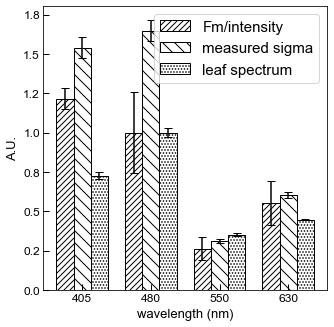

In [21]:
color = ["g", "b", "r"]
labels = ["Fm/intensity", "measured sigma", "leaf spectrum"] 



fill =  [ "////" , "\\\\" , "...." , "xxxx", "oooo", "O"]

p.figsize=(10,10)
fig = p.set_figure("%d", "%0.1f")
ax = fig.gca()
X = np.array([0,1,2,3])
for i, graph in enumerate([ maxi_graph, sigma_graph, leaf_graph]):
    graph = np.array(graph)
    lbd, x, err = graph[:,0], graph[:,1], graph[:,2]

    ax.bar(X + 0.25*i, x, color = "w", width = 0.25, yerr = err,  
                  capsize = 4, label = labels[i], hatch = fill[i], edgecolor = "k")
plt.legend(prop={"size":15})
plt.xlabel("wavelength (nm)")

plt.ylabel("A.U.")
ax.set_xticks(X+0.25)
ax.set_xticklabels(["405", "480", "550", "630"])
plt.savefig(p.save_folder + "spectrum" + p.extension)



In [22]:
sigma_graph

[[405, 1.5400836765426267, 0.06692643413536926],
 [470, 1.6471672544230054, 0.06829629382220453],
 [550, 0.3109686491238928, 0.012543369249548185],
 [630, 0.6054402298199753, 0.018858241576354715]]

In [23]:
lbd

array([405., 470., 550., 640.])

[405. 470. 550. 630.]


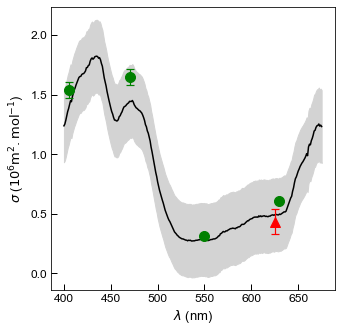

In [24]:
p.figsize=(10,10)
p.xlabel = r'$\lambda$ (nm)'
p.ylabel =  r"$\sigma$ ($\mathrm{10^6 m^2.mol^{-1}}$)"

fig = p.set_figure("%d", "%0.1f")

#spectrum = np.load("spectra/spectrum_N_16.npy")
#plt.plot(spectrum[0], spectrum[1]/spectrum[1][spectrum[0]==470]*1.65, color = 'grey')
#spectrum = np.load("spectra/spectra_chlamy.npy")
#plt.plot(spectrum[0], spectrum[1]/spectrum[1][spectrum[0]==470]*1.65, '--', color = 'grey')
#spectrum = np.load("spectra/spectra_thylakoid.npy")
#plt.plot(spectrum[0], spectrum[1]*1.65, '-.', color = 'grey')
spectrum = np.load("spectra/spectra_average.npy")
y = spectrum[1]*1.44
x = spectrum[0]
x, err = np.load("spectra/spectra_average_std.npy")
plt.plot(spectrum[0], y,color = 'black')
plt.fill_between(x, y-np.max(err), y+np.max(err), color = "lightgrey")


for i, graph in enumerate([sigma_graph]):#[sigma_graph, sigma_pred_graph[0], sigma_pred_graph[1]]):
    graph = np.array(graph)
    lbd, x, err = graph[:,0], graph[:,1], graph[:,2]
    print(lbd)
    plt.errorbar(lbd, x, yerr = err,   fmt = ['o','^', 's'][i], ms=10, 
                 mfc = ["g", "r", "b"][i], elinewidth = 1.2, capsize = 4, capthick = 1.2, color = ["g", "r", "b"][i])
"""  
for i, graph in enumerate([leaf_graph]):#[sigma_graph, sigma_pred_graph[0], sigma_pred_graph[1]]):
    i+=1
    graph = np.array(graph)
    lbd, x, err = graph[:,0], graph[:,1]*1.4, graph[:,2]*1.4
    plt.errorbar(lbd, x, yerr = err,   fmt = ['o','^', 's'][i], ms=10, 
                 mfc = ["g", "r", "b"][i], elinewidth = 1.2, capsize = 4, capthick = 1.2, color = ["g", "r", "b"][i])
"""    
    
plt.errorbar(625, 0.435 , yerr = 0.41*0.25,   fmt = ['o','^', 's'][i+1], ms=10, 
                 mfc = ["g", "r", "b"][i+1], elinewidth = 1.2, capsize = 4, capthick = 1.2, color = ["g", "r", "b"][i+1])
 
p.save_name = 'prediction_spectra_sigma'
plt.savefig('G:/DREAM/from_github/thesis/Intensity_paper/' + p.save_name + p.extension)

In [25]:
x, err = np.load("spectra/spectra_average_std.npy")
#x, y = np.load("spectra/spectra_average.npy")

err[x==405]

array([0.17746115])

## Multiple intensities

LEAF1_blue_506_675/
LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
LEAF1_blue_506_675\2022-07-29_10_15_OJIP_pulse_393_blue
LEAF1_blue_506_675\2022-07-29_10_16_OJIP_pulse_337_blue
LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_225_blue
LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_281_blue
LEAF1_blue_506_675\2022-07-29_10_18_OJIP_pulse_168_blue
LEAF1_blue_506_675\2022-07-29_10_19_OJIP_pulse_112_blue
LEAF1_blue_506_675\2022-07-29_10_20_OJIP_pulse_56_blue
LEAF1_blue_506_675\2022-07-29_10_21_OJIP_pulse_20_blue
LEAF1_blue_506_675\2022-07-29_10_22_OJIP_pulse_73_blue
LEAF1_blue_506_675\2022-07-29_10_23_OJIP_pulse_127_blue
LEAF1_blue_506_675\2022-07-29_10_24_OJIP_pulse_181_blue
LEAF1_blue_506_675\2022-07-29_10_25_OJIP_pulse_235_blue
LEAF1_blue_506_675\2022-07-29_10_26_OJIP_pulse_288_blue
LEAF1_blue_506_675\2022-07-29_10_26_OJIP_pulse_342_blue
LEAF1_blue_506_675\2022-07-29_10_27_OJIP_pulse_396_blue
LEAF1_blue_506_675\2022-07-29_10_28_OJIP_pulse_450_blue


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


LEAF1_blue_506_675/
LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
LEAF1_blue_506_675\2022-07-29_10_15_OJIP_pulse_393_blue
LEAF1_blue_506_675\2022-07-29_10_16_OJIP_pulse_337_blue
LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_225_blue
LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_281_blue
LEAF1_blue_506_675\2022-07-29_10_18_OJIP_pulse_168_blue
LEAF1_blue_506_675\2022-07-29_10_19_OJIP_pulse_112_blue
LEAF1_blue_506_675\2022-07-29_10_20_OJIP_pulse_56_blue
LEAF1_blue_506_675\2022-07-29_10_21_OJIP_pulse_20_blue
LEAF1_blue_506_675\2022-07-29_10_22_OJIP_pulse_73_blue
LEAF1_blue_506_675\2022-07-29_10_23_OJIP_pulse_127_blue
LEAF1_blue_506_675\2022-07-29_10_24_OJIP_pulse_181_blue
LEAF1_blue_506_675\2022-07-29_10_25_OJIP_pulse_235_blue
LEAF1_blue_506_675\2022-07-29_10_26_OJIP_pulse_288_blue
LEAF1_blue_506_675\2022-07-29_10_26_OJIP_pulse_342_blue
LEAF1_blue_506_675\2022-07-29_10_27_OJIP_pulse_396_blue
LEAF1_blue_506_675\2022-07-29_10_28_OJIP_pulse_450_blue


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


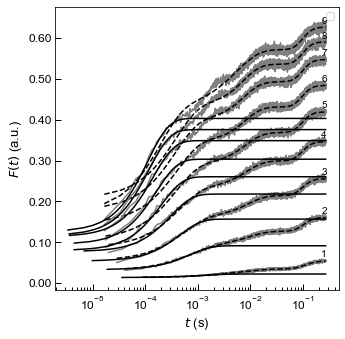

In [26]:
folder_list = ['LEAF1_blue_506_675/']
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.2f")
ax1 = plt.gca()

intensity_list = []
tau_list = []

for N in [50, 10]:
    k = 1
    for i, folder in enumerate(folder_list): 
        print(folder)
        for j, f in enumerate(glob.glob(folder + "/*pulse*")):

            if 'e_0_' not in f:# and j%2==0:
                print(f)
                intensity, params, t, y, ypred, voltage, maxi, purple, filter = multiexp_fit(f, N=N, bode_folder = "2022-07-29_16_33_bode_diagram")
                
                if N==50 and j>8:
                    ax1.semilogx(t, y, c =  "grey")
                    ax1.annotate(k, (t[-200],np.mean(y[-200:])+0.01), xycoords = "data", fontsize=10)
                    ax1.semilogx(t, ypred, "--k")
                    k+=1

                #ax1.plot(t, y, c =  "grey", label = f[0:5])
                #ax1.plot(t, ypred, c = "k")

                if N==10:
                    pos = 3/params[2]
                    #if pos < 5e-4:
                    #    pos = 5e-4
                    #ax1.scatter(pos, sigmoidal_OJIP(params, pos), c = 'k', s = 300)
                    pos_tau = find_nearest(t, pos)
                    params = get_fit(y[:pos_tau], t[:pos_tau])

                    D = 400
                    pos_tau = find_nearest(t, D*params[1])
                    ypred =  exp_decay(params, t[:pos_tau*D])
                    
                    if j>8:
                        ax1.semilogx(t[:pos_tau*D],ypred, "k")
                    
                    
                    intensity_list.append(intensity)
                    tau_list.append(1/params[1])
                    #ax2.annotate(k, (t[18],ypred[12]), xycoords = "data", fontsize=12*2.54)
                    k+=1

                    #plt.scatter(intensity, 1/params[1])
    ax1.legend()
    ax1.set_xlabel("$t$ (s)")
    ax1.set_ylabel("$F(t)$ (a.u.)")

    fig1.savefig(p.save_folder + "intensity_leaf_JC"+p.extension)
  

[7840.24331524865, 7151.79252666145, 6389.573607086648, 4598.195174717105, 5539.41577443679, 3543.125610214587, 2407.4712817210116, 1169.5865454524858, 317.8417759965913, 1556.4296240407364, 2721.518090732702, 3792.569465727102, 4773.097110365011, 5650.598675743227, 6461.160288303199, 7190.200101186894, 7840.24331524865]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              436.0
Date:                Wed, 08 Feb 2023   Prob (F-statistic):                    4.92e-13
Time:                        10:11:29   Log-Likelihood:                         -147.78
No. Observations:                  17   AIC:                                      297.6
Df Residuals:                      16   BIC:                                      298.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4487      0.069     20.881      0.000       1.302       1.596
==============================================================================
Omnibus:                        5.120   Durbin-Watson:                   0.507
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                3.674
Skew:                           1.137   Prob(JB):                        0.159
Kurtosis:                       2.891   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

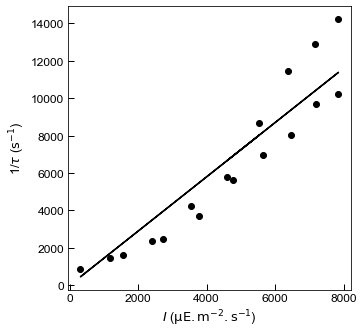

<Figure size 432x288 with 0 Axes>

In [28]:
print(intensity_list)

p.xlabel = label_intensity 
p.ylabel = p.label_tau
fig1 = p.set_figure("%d", "%d")
X = np.array(intensity_list)
Y = np.array(tau_list)
plt.plot(X,Y, "ok")
Yreg, a, results = regression_linear(X,Y)
plt.plot(X, Yreg, "-k")

p.save_name = 'leaf_intensity_single_fit'
u = p.saving(fig1)
results.summary()

### Multiple leaves


In [29]:
folder_list = ['LEAF1_blue_506_675/','LEAF2_blue_506_675/', 'LEAF3_blue_506_675/',
               "../FOLDER_2022_07_28_OJIP_leaf/LEAF1_DO0/", "../FOLDER_2022_07_28_OJIP_leaf/LEAF2_DO0/", "../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green/" ]


## OJIP FITS

LEAF1_blue_506_675/
LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
LEAF2_blue_506_675/
LEAF2_blue_506_675\2022-07-29_13_35_OJIP_pulse_450_blue
LEAF3_blue_506_675/
LEAF3_blue_506_675\2022-07-29_15_31_OJIP_pulse_450_blue
../FOLDER_2022_07_28_OJIP_leaf/LEAF1_DO0/
../FOLDER_2022_07_28_OJIP_leaf/LEAF2_DO0/
../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green/
../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green\2022-07-28_13_34_OJIP_pulse_450


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


LEAF1_blue_506_675/
LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
LEAF2_blue_506_675/
LEAF2_blue_506_675\2022-07-29_13_35_OJIP_pulse_450_blue
LEAF3_blue_506_675/
LEAF3_blue_506_675\2022-07-29_15_31_OJIP_pulse_450_blue
../FOLDER_2022_07_28_OJIP_leaf/LEAF1_DO0/
../FOLDER_2022_07_28_OJIP_leaf/LEAF2_DO0/
../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green/
../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green\2022-07-28_13_34_OJIP_pulse_450


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


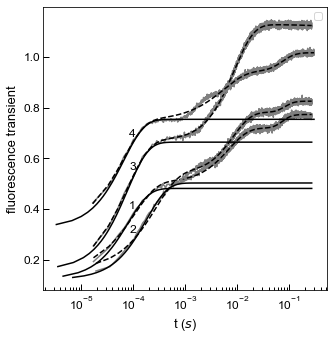

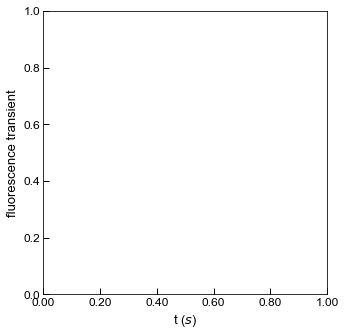

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [30]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
fig2 = p.set_figure("%0.2f", "%0.1f")
ax2 = plt.gca()
for N in [50, 10]:
    k = 1
    for i, folder in enumerate(folder_list): 
        print(folder)
        for f in glob.glob(folder + "/*pulse*")[0:1]:

            if 'e_0_' not in f:
                print(f)
                intensity, params, t, y, ypred, voltage, maxi, purple, filter = multiexp_fit(f, N=N, bode_folder = "2022-07-29_16_33_bode_diagram")
                
                if N==50:
                    ax1.semilogx(t, y, c =  "grey")
                    ax1.annotate(k, (t[4],y[6]), xycoords = "data", fontsize=12)
                    ax1.semilogx(t, ypred, "--k")
                    k+=1

                #ax1.plot(t, y, c =  "grey", label = f[0:5])
                #ax1.plot(t, ypred, c = "k")

                if N==10:
                    pos = 3/params[2]
                    #if pos < 5e-4:
                    #    pos = 5e-4
                    #ax1.scatter(pos, sigmoidal_OJIP(params, pos), c = 'k', s = 300)
                    pos_tau = find_nearest(t, pos)
                    params = get_fit(y[:pos_tau], t[:pos_tau])

                    D = 400
                    pos_tau = find_nearest(t, D*params[1])
                    #ax2.semilogx(t[:pos_tau*D], y[:pos_tau*D], c="grey")
                    ypred =  exp_decay(params, t[:pos_tau*D])
                    ax1.semilogx(t[:pos_tau*D],ypred, "k")
                    #ax2.annotate(k, (t[18],ypred[12]), xycoords = "data", fontsize=12)
                    k+=1

                    #plt.scatter(intensity, 1/params[1])
    ax1.legend()
    ax1.set_xlabel("t ($s$)")
    ax1.set_ylabel("fluorescence transient")
    ax2.set_xlabel("t ($s$)")
    ax2.set_ylabel("fluorescence transient")
    #if N==50:
    p.save_name = "fits_various_leaves_JC"
    p.saving(fig1)
    #if N==10:
    #    fig2.savefig(p.save_folder + "/fits_various_leaves_exp"+p.extension)

In [31]:
folder_list = ['../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675/','../FOLDER_2022_07_29_OJIP_leaf/LEAF2_blue_506_675/', '../FOLDER_2022_07_29_OJIP_leaf/LEAF3_blue_506_675/',
               "../FOLDER_2022_07_28_OJIP_leaf/LEAF5_DO0_bis/",
               "../FOLDER_2022_07_28_OJIP_leaf/LEAF1_DO0_bis/", "../FOLDER_2022_07_28_OJIP_leaf/LEAF2_DO0_bis/", "../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green/",
              #"../FOLDER_2022_06_23_extract_chloroplast/chloroplast_of_the_cat/",
              "../FOLDER_2022_05_09_OJIP_leaf/leaf1/", "../FOLDER_2022_05_09_OJIP_leaf/leaf2/",
              "../FOLDER_2022_01_17_OJIP_leaf/LEAF1_DO0/", "../FOLDER_2022_01_17_OJIP_leaf/LEAF2_DO0/", "../FOLDER_2022_01_17_OJIP_leaf/LEAF3_DO0/",
               "../FOLDER_2022_01_17_OJIP_leaf/LEAF4_DO0/","../FOLDER_2022_01_17_OJIP_leaf/LEAF5_DO0/",
                "../FOLDER_2022_01_17_OJIP_leaf/LEAF6_DO0/", "../FOLDER_2022_01_17_OJIP_leaf/LEAF7_DO0/", "../FOLDER_2022_01_17_OJIP_leaf/LEAF8_DO0/",
               #"../FOLDER_2022_01_17_OJIP_leaf/ALGAE1_DO0/"
              ]
       

data_list = ['LEAF1_blue_506_675','LEAF2_blue_506_675', 'LEAF3_blue_506_675',
               "LEAF5_DO0_bis",
               "LEAF1_DO0_bis", "LEAF2_DO0_bis", "LEAF3_DO0_green",
              #"chloroplast_of_the_cat",
              "leaf1", "leaf2",
              "LEAF1_DO0", "LEAF2_DO0", "LEAF3_DO0","LEAF4_DO0","LEAF5_DO0",
                "LEAF6_DO0", "LEAF7_DO0", "LEAF8_DO0",
             #"ALGAE1_DO0", "OJIP_actiivated_1", "OJIP_activated_2", "OJIP_activated_3"
            ]
       
    
    
bode_list = ["2022-07-29_16_33_bode_diagram", "2022-07-29_16_33_bode_diagram", "2022-07-29_16_33_bode_diagram",
             "2022-07-29_16_33_bode_diagram", 
            "2022-07-29_16_33_bode_diagram","2022-07-29_16_33_bode_diagram","2022-07-29_16_33_bode_diagram",
             #"2022-07-29_16_33_bode_diagram", 
             "../2022-05-11_16_24_bode_diagram_DRONPA2_CALIB/", "../2022-05-11_16_24_bode_diagram_DRONPA2_CALIB/",
             "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram",
             "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram","../2022-01-13_12_02_bode_diagram", 
             #"../2022-01-13_12_02_bode_diagram", 
             #"../2021-11-03_15_54_bode_diagram", "../2021-11-03_15_54_bode_diagram", "../2021-11-03_15_54_bode_diagram", "../2021-11-03_15_54_bode_diagram"
            ]
             
item_list = ["young leaf", "hairy leaf", "_nolegend_", 
             "_nolegend_", 
             "_nolegend_", "_nolegend_", "_nolegend_",
             #"chloroplast",
             "_nolegend_","_nolegend_",
             "_nolegend_","_nolegend_","old leaf","_nolegend_","_nolegend_",
             "_nolegend_","_nolegend_","_nolegend_", 
             #"algae",
            #"_nolegend_","_nolegend_","_nolegend_","_nolegend_"
            ]

marker_spe = ["<", "+", "<",
          "<",
          "<", "<", "<", 
          #"o",
          "<", "<",
          "^", "<", "^", "<", "<", 
          "<", "^", "<", 
              #"x",
             "x","x","x","x"]


marker_spe = ["^", "^", "^",
          "^",
          "^", "^", "^", 
          #"o",
          "^", "^",
          "^", "^", "^", "^", "^", 
          "^", "^", "^",
              #"x",
             "x","x","x","x"]

../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675/
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_15_OJIP_pulse_393_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_16_OJIP_pulse_337_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_225_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_281_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_18_OJIP_pulse_168_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_19_OJIP_pulse_112_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_20_OJIP_pulse_56_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_21_OJIP_pulse_0_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_21_OJIP_pulse_20_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_22_OJIP_pulse_73_bl

IndexError: list index out of range

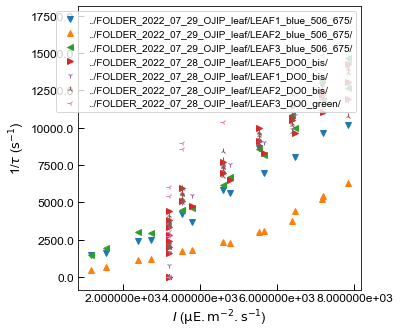

In [32]:

p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


tot_int = {}
tot_tau = {}
tot_maxi = {}
tot_voltage = {}
tot_purple = {}


for i, folder in enumerate(folder_list): 
        print(folder)
        tot_int[folder] = []
        tot_tau[folder] = []
        tot_maxi[folder] = []
        tot_voltage[folder] = []
        tot_purple[folder] = []

        for f in glob.glob(folder + "/*pulse*"):
            print(f)
            if 'e_0_' not in f and 'e_20_' not in f:
                intensity, params, t, y, ypred, voltage, maxi, intensity_purple, filter = multiexp_fit(f, bode_folder = bode_list[i])
                if voltage>0 and filter==0:
                    pos = 3/params[2]

                    pos_tau = find_nearest(t, pos)

                    params = get_fit(y[:pos_tau], t[:pos_tau])
                    tot_int[folder].append(intensity)
                    tot_tau[folder].append(params)
                    tot_maxi[folder].append(maxi)
                    tot_voltage[folder].append(voltage)
                    tot_purple[folder].append(intensity_purple)
        X = np.array(tot_int[folder])
        Y = 1/np.array(tot_tau[folder])[:,1]
        plt.plot(X, Y, marker[i+3], label = folder)
        np.save("data_fit" + os.path.split(os.path.split(folder)[0])[1] + ".npy", np.array([X,Y])) 
        plt.legend()  
ax1.legend()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("fluorescence transient")

fig1.savefig("G:/DREAM/from_github/thesis/Figures/OJIP/tau_curves_OJIP_mutliple_leaves.png")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

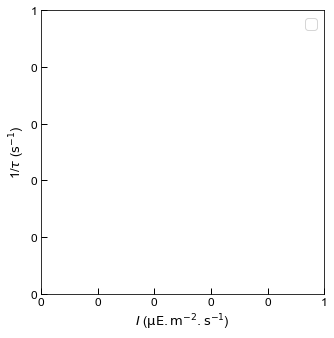

<Figure size 432x288 with 0 Axes>

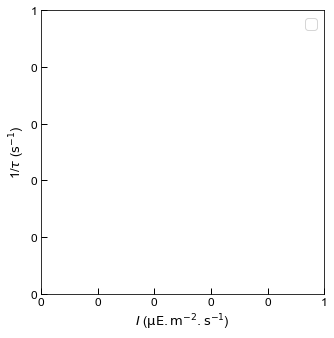

<Figure size 432x288 with 0 Axes>

In [34]:
for ind in [0,1]:
    p.figsize = (10, 10)
    fig1 = p.set_figure("%d", "%d")
    ax1 = plt.gca()

    for i, file in enumerate(data_list):
        if marker_spe[i]=="<" and  i<6:
            [X,Y] = np.load("data_fit/" + file + ".npy")
            if ind:
                plt.scatter(X, Y, marker= marker[i], edgecolors = "k", facecolors="none", label = "leaf %d"%i)
            else: 
                plt.scatter(X, Y, marker= marker[i], edgecolors = "k", facecolors="none", label =  "leaf %d"%i)

            plt.legend()  
        ax1.legend(prop={"size":15})
        ax1.set_xlabel(label_intensity)
        ax1.set_ylabel(p.label_tau)
    if ind:
        p.save_name = "tau_curves_OJIP_young_leaves"
        p.saving(fig1)
    else: 
        p.save_name = 'tau_curves_OJIP_young_leaves_loglog'
        p.saving(fig1)



NameError: name 'label_tau' is not defined

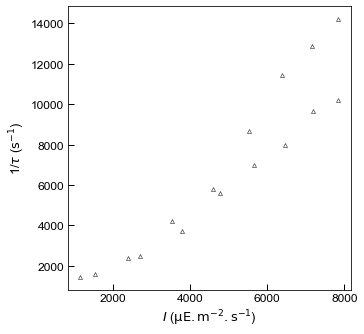

In [35]:
x = []
y  =  []
for ind in [0,1]:
    p.figsize = (10, 11)
    fig1 = p.set_figure("%d", "%d")
    ax1 = plt.gca()

    for i, file in enumerate(data_list):
        
        [X,Y] = np.load("data_fit/" + file + ".npy")
        x.append(X)
        y.append(Y)
        kept = X>500
        X = X[kept]
        Y=Y[kept]
        if ind:
            plt.plot(X, Y, marker= marker_spe[i], linestyle="", markersize=4, markeredgewidth=0.5, markeredgecolor = "k", markerfacecolor="none", label = "leaf %d"%i)
        else: 
            plt.plot(X, Y, marker= marker_spe[i], linestyle="", markersize=4, markeredgewidth=0.5, markeredgecolor = "k", markerfacecolor="none", label =  "leaf %d"%i)

        #ax1.legend(prop={"size":15})
        ax1.set_xlabel(label_intensity)
        ax1.set_ylabel(label_tau)

    if ind:
        p.save_name = "tau_curves_OJIP_PAs"
        p.saving(fig1)
    else: 
        p.save_name = 'tau_curves_OJIP_PAs_loglog'
        p.saving(fig1)



In [ ]:
x = np.concatenate(x)
y = np.concatenate(y)

In [ ]:
plt.figure()
sigma = []
for file in data_list: 
    [X,Y] = np.load("data_fit/" + file + ".npy")

    plt.scatter(X,Y)
    Yreg, a, results = regression_linear(X,Y)
    #plt.plot(x,Yreg, label = "a=%0.2e, r²=%0.2f"%(a, results.rsquared))
    #plt.legend()
    sigma.append(a[0])

In [ ]:
p.save_folder

In [ ]:
fig = p.set_figure("%0.1f", "%d")
ax = plt.gca()

p.save_name = "chlorophyll_sigma_hist"
p.extension = ".png"
plt.xlabel(r"$\sigma_{PA,470}$ ($\mathrm{10^6 m^2.mol^{-1}}$)")
plt.ylabel("")

_, bins, _ = plt.hist(np.array(sigma), bins=10, range = [0,2.5], density= False, alpha=1, facecolor = "white", edgecolor = "black")


p.saving(fig)
print(np.mean(sigma))
print(np.std(sigma)*2)


## wide filter range

In [ ]:
folder_list = ["LEAF4_blue_665_657_filter_012"]

p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
fig2 = p.set_figure("%0.2f", "%0.1f")
ax2 = plt.gca()

intensity_list = []
tau_list = []
voltage_list  = []
for N in [50, 10]:
    for i, folder in enumerate(folder_list): 
        print(folder)
        for j, f in enumerate(glob.glob(folder + "/*pulse*")):

            if 'e_0_' not in f:
                print(f)
                intensity, params, t, y, ypred, voltage, maxi, purple, filter = multiexp_fit(f, N=N)

                intensity_list.append(intensity)
                voltage_list.append(voltage)
                
                if N==50 and j%2==0:
                    ax1.semilogx(t, y, c =  "grey")
                    ax1.annotate(i, (t[5],y[6]), xycoords = "data")
                    ax1.semilogx(t, ypred, c = "k")

                #ax1.plot(t, y, c =  "grey", label = f[0:5])
                #ax1.plot(t, ypred, c = "k")

                if N==10:
                    pos = 3/params[2]
                    #if pos < 5e-4:
                    #    pos = 5e-4
                    #ax1.scatter(pos, sigmoidal_OJIP(params, pos), c = 'k', s = 300)
                    pos_tau = find_nearest(t, pos)
                    params = get_fit(y[:pos_tau], t[:pos_tau])

                    D = 400
                    pos_tau = find_nearest(t, D*params[1])
                    #ax2.semilogx(t[:pos_tau*D], y[:pos_tau*D], c="grey")
                    ypred =  exp_decay(params, t[:pos_tau*D])
                    tau_list.append(params[1])
                    if j%2==0:
                        ax1.semilogx(t[:pos_tau*D],ypred, c="k")
                    #ax2.annotate(i, (t[0],ypred[1]), xycoords = "data")


                    #plt.scatter(intensity, 1/params[1])
    ax1.legend()
    ax1.set_xlabel("$t$ (s)")
    ax1.set_ylabel("$F(t)$ (a.u.)")
    ax2.set_xlabel("$t$ (s)")
    ax2.set_ylabel("$F(t)$ (a.u.)")
    if N==50:
        fig1.savefig(p.save_folder + "fits_widerange_JC.png")
    if N==10:
        fig2.savefig(p.save_folder + "/fits_widerange_exp.png")

In [ ]:
intensity_list = np.array(intensity_list[0:len(tau_list)])
tau_list = np.array(tau_list)
ind = (np.array(voltage_list[0:len(tau_list)])>0)*(1/tau_list<1e5)

X = intensity_list[ind]
Y = 1/np.array(tau_list)[ind]

Yreg, a, results = regression_linear(X,Y)

fig = p.set_figure()
plt.xlabel(label_intensity)
plt.ylabel(label_tau)
plt.loglog(X, Yreg, 'k')
plt.loglog(X, Y, 'ok')
p.save_name = "wide_range_intensity_leaf"
p.saving(fig)
results.summary()

In [ ]:
X

In [ ]:
len(tau_list)